# Compute Coverage

This example demonstrates how to use direct function calls of the low-level TAT-C library to perform coverage analysis over a region of interest.

Similar to the _Collect Observations_ example, the first steps are to define the satellites for the mission. This example again uses the NOAA-20 satellite with a two-line elements model from July 2022 and a VIIRS instrument with field of regard computed based on a 834km altitude and 3000km swath width.

In [1]:
from tatc import utils
from tatc.schemas import Instrument, Satellite, TwoLineElements

viirs = Instrument(
    name="VIIRS",
    field_of_regard=utils.swath_width_to_field_of_regard(834000, 3000000),
)
noaa20 = Satellite(
    name="NOAA 20",
    orbit=TwoLineElements(
        tle=[
            "1 43013U 17073A   22195.78278435  .00000038  00000+0  38919-4 0  9996",
            "2 43013  98.7169 133.9110 0001202  63.8768 296.2532 14.19561306241107",
        ]
    ),
    instruments=[viirs],
)

The mission considers a 30-day integration period starting at noon UTC on July 14, 2022.

In [2]:
from datetime import datetime, timedelta, timezone

start = datetime(year=2022, month=7, day=14, hour=12, tzinfo=timezone.utc)
end = start + timedelta(days=30)

Coverage analyses typically compute metrics over a spatial region. The `generate_cubed_sphere_points` method in TAT-C distributes sample points over a uniform latitude-longitude grid, scaled based on a characteristic distance, set to 5000 km in this example.

In [3]:
from tatc.generation import generate_cubed_sphere_points

points_df = generate_cubed_sphere_points(5000e3)
display(points_df)

,point_id,geometry
0,0,POINT (-157.51699 -67.51699)
1,1,POINT (-112.55097 -67.51699)
2,2,POINT (-67.58495 -67.51699)
3,3,POINT (-22.61894 -67.51699)
4,4,POINT (22.34708 -67.51699)
5,5,POINT (67.31310 -67.51699)
6,6,POINT (112.27912 -67.51699)
7,7,POINT (157.24514 -67.51699)
8,8,POINT (-157.51699 -22.55097)
9,9,POINT (-112.55097 -22.55097)


The resulting 32 points are distributed over the globe.

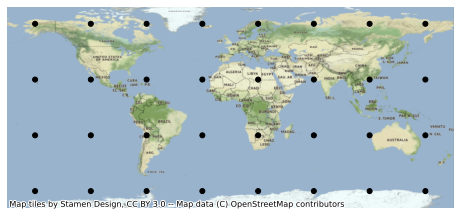

In [4]:
import geoplot as gplt
import contextily as ctx

ax = gplt.pointplot(points_df, color="k")
ctx.add_basemap(ax, crs=points_df.crs)

As the TAT-C analysis functions require points specified in the TAT-C format, rather than a data frame, it is often convenient to convert and store the points in a separate list.

In [5]:
from tatc.schemas import Point

points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

The `collect_observations` method can be called either using sequential or parallel computation (using `joblib`). While there is some overhead associated with parallel computation, it is usually faster on modern multi-core machines.

In [6]:
from tatc.analysis import collect_observations

import time

t = time.time()
results_list = [
    collect_observations(point, noaa20, viirs, start, end) for point in points
]
print(f"Sequential computation completed in {time.time() - t:.2f} seconds")

Sequential computation completed in 10.77 seconds


In [7]:
from tatc.analysis import collect_observations

import time
from joblib import Parallel, delayed

t = time.time()
results_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(point, noaa20, viirs, start, end) for point in points
)
print(f"Parallel computation completed in {time.time() - t:.2f} seconds")

Parallel computation completed in 4.44 seconds


Next, we concatenate the results into a single data frame.

In [8]:
import pandas as pd

results = pd.concat(results_list, ignore_index=True)
display(results)

,point_id,geometry,satellite,instrument,start,end,epoch,sat_alt,sat_az
0,0,POINT (-157.51699 -67.51699),NOAA 20,VIIRS,2022-07-14 23:30:13.504937+00:00,2022-07-14 23:35:24.700151+00:00,2022-07-14 23:32:49.102544+00:00,30.035319,90.532033
1,0,POINT (-157.51699 -67.51699),NOAA 20,VIIRS,2022-07-15 01:09:57.221103+00:00,2022-07-15 01:17:36.070193+00:00,2022-07-15 01:13:46.645648+00:00,84.027201,71.176629
2,0,POINT (-157.51699 -67.51699),NOAA 20,VIIRS,2022-07-15 02:50:32.021280+00:00,2022-07-15 02:56:59.202403+00:00,2022-07-15 02:53:45.611841500+00:00,41.004603,223.802850
3,0,POINT (-157.51699 -67.51699),NOAA 20,VIIRS,2022-07-15 04:31:23.154019+00:00,2022-07-15 04:34:35.637143+00:00,2022-07-15 04:32:59.395581+00:00,23.798801,200.198288
4,0,POINT (-157.51699 -67.51699),NOAA 20,VIIRS,2022-07-15 07:48:30.230323+00:00,2022-07-15 07:52:58.807543+00:00,2022-07-15 07:50:44.518933+00:00,27.400102,151.773103
...,...,...,...,...,...,...,...,...,...
4782,31,POINT (157.24514 67.38106),NOAA 20,VIIRS,2022-08-12 18:28:49.325939+00:00,2022-08-12 18:34:03.183661+00:00,2022-08-12 18:31:26.254800+00:00,31.260813,324.671157
4783,31,POINT (157.24514 67.38106),NOAA 20,VIIRS,2022-08-12 21:48:42.817756+00:00,2022-08-12 21:49:48.545180+00:00,2022-08-12 21:49:15.681468+00:00,21.116289,13.096140
4784,31,POINT (157.24514 67.38106),NOAA 20,VIIRS,2022-08-12 23:25:35.417650+00:00,2022-08-12 23:31:03.448822+00:00,2022-08-12 23:28:19.433236+00:00,32.782441,37.026059
4785,31,POINT (157.24514 67.38106),NOAA 20,VIIRS,2022-08-13 01:04:19.959524+00:00,2022-08-13 01:11:46.499770+00:00,2022-08-13 01:08:03.229647+00:00,73.846580,59.292237


The `aggregate_observations` function computes the access and revisit statistics for each point.

In [9]:
from tatc.analysis import aggregate_observations

aggregated_results = aggregate_observations(results)
display(aggregated_results)

,geometry,point_id,satellite,instrument,start,epoch,end,access,revisit
0,POINT (-157.51699 -67.51699),0,NOAA 20,VIIRS,2022-07-14 23:30:13.504937+00:00,2022-07-14 23:32:49.102543872+00:00,2022-07-14 23:35:24.700151+00:00,0 days 00:05:11.195214,NaT
1,POINT (-157.51699 -67.51699),0,NOAA 20,VIIRS,2022-07-15 01:09:57.221103+00:00,2022-07-15 01:13:46.645647872+00:00,2022-07-15 01:17:36.070193+00:00,0 days 00:07:38.849090,0 days 01:34:32.520952
2,POINT (-157.51699 -67.51699),0,NOAA 20,VIIRS,2022-07-15 02:50:32.021280+00:00,2022-07-15 02:53:45.611841536+00:00,2022-07-15 02:56:59.202403+00:00,0 days 00:06:27.181123,0 days 01:32:55.951087
3,POINT (-157.51699 -67.51699),0,NOAA 20,VIIRS,2022-07-15 04:31:23.154019+00:00,2022-07-15 04:32:59.395580928+00:00,2022-07-15 04:34:35.637143+00:00,0 days 00:03:12.483124,0 days 01:34:23.951616
4,POINT (-157.51699 -67.51699),0,NOAA 20,VIIRS,2022-07-15 07:48:30.230323+00:00,2022-07-15 07:50:44.518932992+00:00,2022-07-15 07:52:58.807543+00:00,0 days 00:04:28.577220,0 days 03:13:54.593180
...,...,...,...,...,...,...,...,...,...
4782,POINT (157.24514 67.38106),31,NOAA 20,VIIRS,2022-08-12 18:28:49.325939+00:00,2022-08-12 18:31:26.254799872+00:00,2022-08-12 18:34:03.183661+00:00,0 days 00:05:13.857722,0 days 01:33:21.770501
4783,POINT (157.24514 67.38106),31,NOAA 20,VIIRS,2022-08-12 21:48:42.817756+00:00,2022-08-12 21:49:15.681467904+00:00,2022-08-12 21:49:48.545180+00:00,0 days 00:01:05.727424,0 days 03:14:39.634095
4784,POINT (157.24514 67.38106),31,NOAA 20,VIIRS,2022-08-12 23:25:35.417650+00:00,2022-08-12 23:28:19.433235968+00:00,2022-08-12 23:31:03.448822+00:00,0 days 00:05:28.031172,0 days 01:35:46.872470
4785,POINT (157.24514 67.38106),31,NOAA 20,VIIRS,2022-08-13 01:04:19.959524+00:00,2022-08-13 01:08:03.229647104+00:00,2022-08-13 01:11:46.499770+00:00,0 days 00:07:26.540246,0 days 01:33:16.510702


The `reduce_observations` function computes descriptive statistics for each point.

In [10]:
from tatc.analysis import reduce_observations

reduced_results = reduce_observations(aggregated_results)
display(reduced_results)

,point_id,geometry,access,revisit,samples
0,0,POINT (-157.51699 -67.51699),0 days 00:05:28.705247,0 days 02:56:33.403049,234
1,1,POINT (-112.55097 -67.51699),0 days 00:05:27.187784,0 days 02:55:27.374120,236
2,2,POINT (-67.58495 -67.51699),0 days 00:05:28.226225,0 days 02:55:47.326095,235
3,3,POINT (-22.61894 -67.51699),0 days 00:05:28.703592,0 days 02:56:12.255015,235
4,4,POINT (22.34708 -67.51699),0 days 00:05:29.869214,0 days 02:57:19.324365,233
5,5,POINT (67.31310 -67.51699),0 days 00:05:26.638983,0 days 02:57:41.792189,236
6,6,POINT (112.27912 -67.51699),0 days 00:05:29.207116,0 days 02:58:25.816311,235
7,7,POINT (157.24514 -67.51699),0 days 00:05:29.089517,0 days 02:59:13.646230,234
8,8,POINT (-157.51699 -22.55097),0 days 00:05:48.303140,0 days 09:52:38.681883,72
9,9,POINT (-112.55097 -22.55097),0 days 00:05:52.743758,0 days 10:01:06.235517,71


Finally, we can visualize results, first converting metrics to numeric formats.

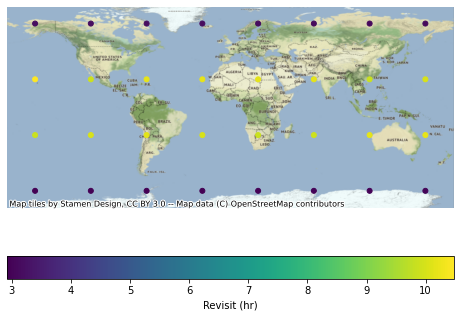

In [11]:
import geoplot as gplt
import contextily as ctx

reduced_results["revisit_hr"] = reduced_results.revisit / timedelta(hours=1)
ax = gplt.pointplot(
    reduced_results,
    hue="revisit_hr",
    legend=True,
    legend_kwargs={"label": "Revisit (hr)", "orientation": "horizontal"},
)
ctx.add_basemap(ax, crs=reduced_results.crs)

Coverage analyses can also be aggregated to spatial regions for improved visualizations. This example focuses on a smaller spatial region covering the Continental United States (CONUS) defined by a Polygon. Similar to how the `generate_cubed_sphere_points` generates uniformly-distributed points (in latitude/longitude), the function `generate_cubed_sphere_cells` generates uniformly distributed cells. This example uses twice the characteristic distance (1000 km vs. 500 km) such that each cell covers about four points.

,cell_id,geometry
0,486,"POLYGON ((-125.00000 19.00000, -125.00000 26.9..."
1,526,"POLYGON ((-125.00000 26.91165, -125.00000 35.9..."
2,566,"POLYGON ((-125.00000 35.90485, -125.00000 44.8..."
3,606,"POLYGON ((-125.00000 44.89806, -125.00000 50.0..."
4,487,"POLYGON ((-117.04757 19.00000, -117.04757 26.9..."
5,527,"POLYGON ((-117.04757 26.91165, -117.04757 35.9..."
6,567,"POLYGON ((-117.04757 35.90485, -117.04757 44.8..."
7,607,"POLYGON ((-117.04757 44.89806, -117.04757 50.0..."
8,488,"POLYGON ((-108.05437 19.00000, -108.05437 26.9..."
9,528,"POLYGON ((-108.05437 26.91165, -108.05437 35.9..."


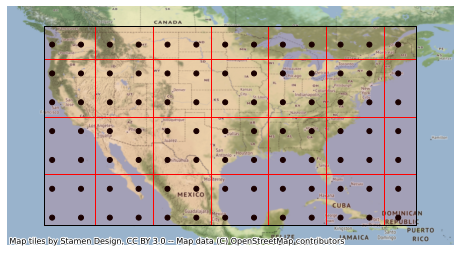

In [12]:
from shapely.geometry import Polygon

target = Polygon([(-125, 50), (-67, 50), (-67, 19), (-125, 19), (-125, 50)])

import geopandas as gpd

target_area = gpd.GeoDataFrame({"geometry": target}, index=[0], crs="EPSG:4326")

from tatc.generation.points import generate_cubed_sphere_points
from tatc.generation.cells import generate_cubed_sphere_cells

points_df = generate_cubed_sphere_points(500e3, mask=target)
cells_df = generate_cubed_sphere_cells(1000e3, mask=target)

display(cells_df)

import geoplot as gplt
import contextily as ctx

ax = gplt.pointplot(points_df, color="k")
gplt.polyplot(cells_df, ax=ax, edgecolor="r", facecolor=(1, 0, 0, 0.1), zorder=1)
gplt.polyplot(target_area, ax=ax, zorder=2)
ctx.add_basemap(
    ax,
    crs=points_df.crs,
)

Similar to the prior case, coverage analysis can be performed for each point.

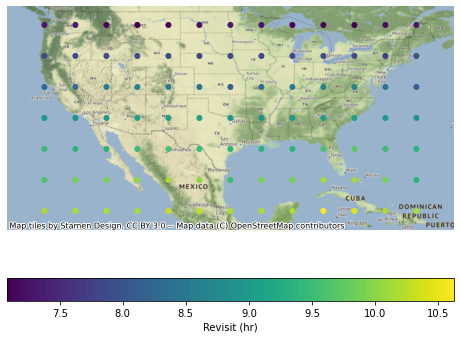

In [13]:
from tatc.schemas import Point

points = points_df.apply(
    lambda r: Point(id=r.point_id, latitude=r.geometry.y, longitude=r.geometry.x),
    axis=1,
)

from joblib import Parallel, delayed
from tatc.analysis.coverage import collect_observations

results_list = Parallel(n_jobs=-1)(
    delayed(collect_observations)(point, noaa20, viirs, start, end) for point in points
)
results = pd.concat(results_list, ignore_index=True)

from tatc.analysis import aggregate_observations

aggregated_results = aggregate_observations(results)

from tatc.analysis.coverage import reduce_observations

reduced_results = reduce_observations(aggregated_results)

import geoplot as gplt
import contextily as ctx

reduced_results["revisit_hr"] = reduced_results.apply(
    lambda r: r["revisit"] / timedelta(hours=1), axis=1
)
ax = gplt.pointplot(
    reduced_results,
    hue="revisit_hr",
    legend=True,
    legend_kwargs={"label": "Revisit (hr)", "orientation": "horizontal"},
)
ctx.add_basemap(
    ax,
    crs=reduced_results.crs,
)

In addition, the results can be gridded using the specified cells.

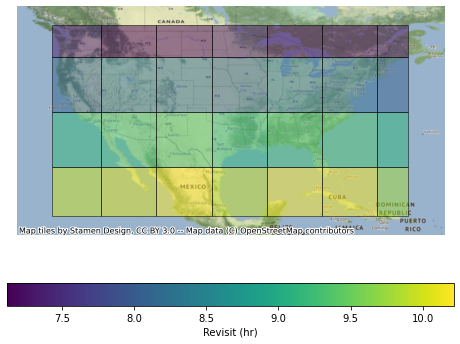

In [14]:
from tatc.analysis.coverage import grid_observations

grid_results = grid_observations(reduced_results, cells_df)

import geoplot as gplt
import contextily as ctx

grid_results["revisit_hr"] = grid_results.apply(
    lambda r: r["revisit"] / timedelta(hours=1), axis=1
)
ax = gplt.choropleth(
    grid_results,
    hue="revisit_hr",
    alpha=0.5,
    legend=True,
    legend_kwargs={"label": "Revisit (hr)", "orientation": "horizontal"},
)
ctx.add_basemap(
    ax,
    crs=reduced_results.crs,
)